# Script to generate external source fiels in hdf5
# Also, check the source file from the generated hdf5
## - The dimension should be $(n_y, n_x, n_z)$

In [1]:
import sys
import os

# Get current Python version
version = sys.version
print("Python Version:", version)

# Get current Python executable path
path = sys.executable
print("Python Path:", path)


Python Version: 3.9.5 (default, Jun  4 2021, 12:28:51) 
[GCC 7.5.0]
Python Path: /marconi/home/userexternal/klim0000/miniconda3/bin/python


In [2]:
import gbspy as g
import numpy as np
import matplotlib.pyplot as plt
import os
import h5py

import multiprocessing as mp
from matplotlib.animation import FuncAnimation
from scipy.interpolate import griddata
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset
from matplotlib.ticker import AutoMinorLocator
import matplotlib.lines as mlines
from matplotlib.ticker import AutoMinorLocator

import sys  
#sys.path.insert(0, '/marconi/home/userexternal/klim0000/miniconda3/lib/python3.9/site-packages/gbs_python/gbspy')
#sys.path.append('/marconi/home/userexternal/klim0000/miniconda3/lib/python3.9/site-packages/gbs_python/gbspy')

# Get the current working directory|
cwd = os.getcwd()

# ---Path to the simulations on Marconi---
os.chdir('/marconi_scratch/userexternal/klim0000/GBS/DN_neutrals/DN_neu_2D')

# Print the current working directory
print("Current working directory: {0}".format(cwd))

# Load GBS simulations
s=g.Sim()

<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


Current working directory: /marconi/home/userexternal/klim0000/jupyter_notebook/GBS_DN_tria


# Generate source profiles

In [3]:
t_final = s.time[0]
t_init = t_final 

tempe = s.get_field('Te', t1=t_init, t2=t_final)
dens = s.get_field('n', t1=t_init, t2=t_final)

tempe = np.mean(dens, axis=(2,3))
dens = np.mean(dens, axis=(2,3))

In [9]:
x0n = s.attribute['x0_EC_theta']
x0t = s.attribute['x0_EC_tempe']

#x0n = 110 #70 #(DPT) # 110 (DNT)
x0t = 170 #70 #(DPT) # 110 (DNT)
print("The position of x0n and x0t =", x0n,"/", x0t)

#ix0n = s.find_ind(s.x0 + x0n, s.x)
#ix0t = s.find_ind(s.x0 + x0t, s.x)
#print("The indexe of x0n and x0t =", ix0n,"/", ix0t)

wn = s.attribute['wEC_theta']
wt = s.attribute['wEC_tempe']
print("The width of wn and wt =", wn,"/", wt)


# Amplitude of the source
An = s.attribute['SEC_theta']
At = s.attribute['SEC_tempe']
print("The amplitude of An and At =", An,"/", At)

Psi = s.Psi
#psi0n = Psi[s.iy0, ix0n]
#psi0t = Psi[s.iy0, ix0t]

Bpol = s.dpsidx_v**2 + s.dpsidy_v**2
Xpt_coord = np.unravel_index(np.argmin(Bpol[Bpol > 0]), s.dpsidx_v.shape)

print("The corodinate of the X-point =", Xpt_coord)

The position of x0n and x0t = 170.0 / 170
The width of wn and wt = 1000.0 / 1500.0
The amplitude of An and At = 0.3 / 0.3
The corodinate of the X-point = (62, 151)


In [10]:
# For DN
with open('equilibrium') as f:
    lines = f.readlines()
    xmag_str=lines[-5]
    y0_source_str=lines[-4]
    Yxpt_str=lines[-3]
    Yxpt1_str=lines[-2]

xmag_split = xmag_str.split('=')
y0_source_split = y0_source_str.split('=')
Yxpt_split = Yxpt_str.split('=')
Yxpt1_split = Yxpt1_str.split('=')


xmag = float(xmag_split[1].strip())
y0_source = float(y0_source_split[1].strip())
Yxpt = float(Yxpt_split[1].strip())
Yxpt1 = float(Yxpt1_split[1].strip())

for iy in range(0, s.ny-1):  # +1 since Python's range end is exclusive
    if s.y[iy] - y0_source <= 0 and s.y[iy + 1] - y0_source > 0:
        iysource = iy
        

# Search in xarray for ixsource
for ix in range(0, s.nx-1):
    if s.x[ix] - x0n - xmag <= 0 and s.x[ix + 1] - x0n - xmag > 0:
        ixsource_n = ix
        
for ix in range(0, s.nx-1):
    if s.x[ix] - x0t - xmag <= 0 and s.x[ix + 1] - x0t - xmag > 0:
        ixsource_t = ix
        

if iysource is not None and ixsource_n and ixsource_t is not None:
    psi_eq_n = s.Psi[iysource][ixsource_n]
    psi_eq_t = s.Psi[iysource][ixsource_t]

# Compute source

In [11]:
print(s.nx, s.ny, s.nz)
print(s.ixxpt, s.iyxpt)
print(np.shape(Psi))
iyxpt = s.iyxpt
iyxpt2 = s.ny-s.iyxpt
#s.y[s.iyxpt]
#s.y[s.ny-s.iyxpt]
rorhos = 700

304 404 1
151 62
(404, 304)


In [12]:
# Density source (Local flux)
Sn = [[0 for x in range(s.nx)] for y in range(s.ny)]
St = [[0 for x in range(s.nx)] for y in range(s.ny)]

for i in range(s.ny):
    for j in range(s.nx):
        if (s.y[i] > Yxpt) and (s.y[i]< Yxpt1):
            #Sn[i][j]= An * np.exp(-(Psi[i][j] - psi_eq_n)**2/wn**2) 
            Sn[i][j] = An/2 * (np.tanh(-(Psi[i][j] - psi_eq_n)/wn)+1)
            St[i][j] = At/2 * (np.tanh(-(Psi[i][j] - psi_eq_t)/wt)+1)
        else:
            Sn[i][j] = 0
            St[i][j] = 0

            
Sp = dens * St + tempe * Sn

Sn_array = np.array(np.transpose(Sn)); St_array = np.array(np.transpose(St)); Sp_array = np.array(np.transpose(Sp))

Sn_3D = np.repeat(Sn_array[np.newaxis, :, :], s.nz, axis=0)
St_3D = np.repeat(St_array[np.newaxis, :, :], s.nz, axis=0)
Sp_3D = np.repeat(Sp_array[np.newaxis, :, :], s.nz, axis=0)

print(np.shape(Sn_3D), np.shape(St_3D), np.shape(Sp_3D))

(1, 304, 404) (1, 304, 404) (1, 304, 404)


## Please check the dimension of the generated source terms

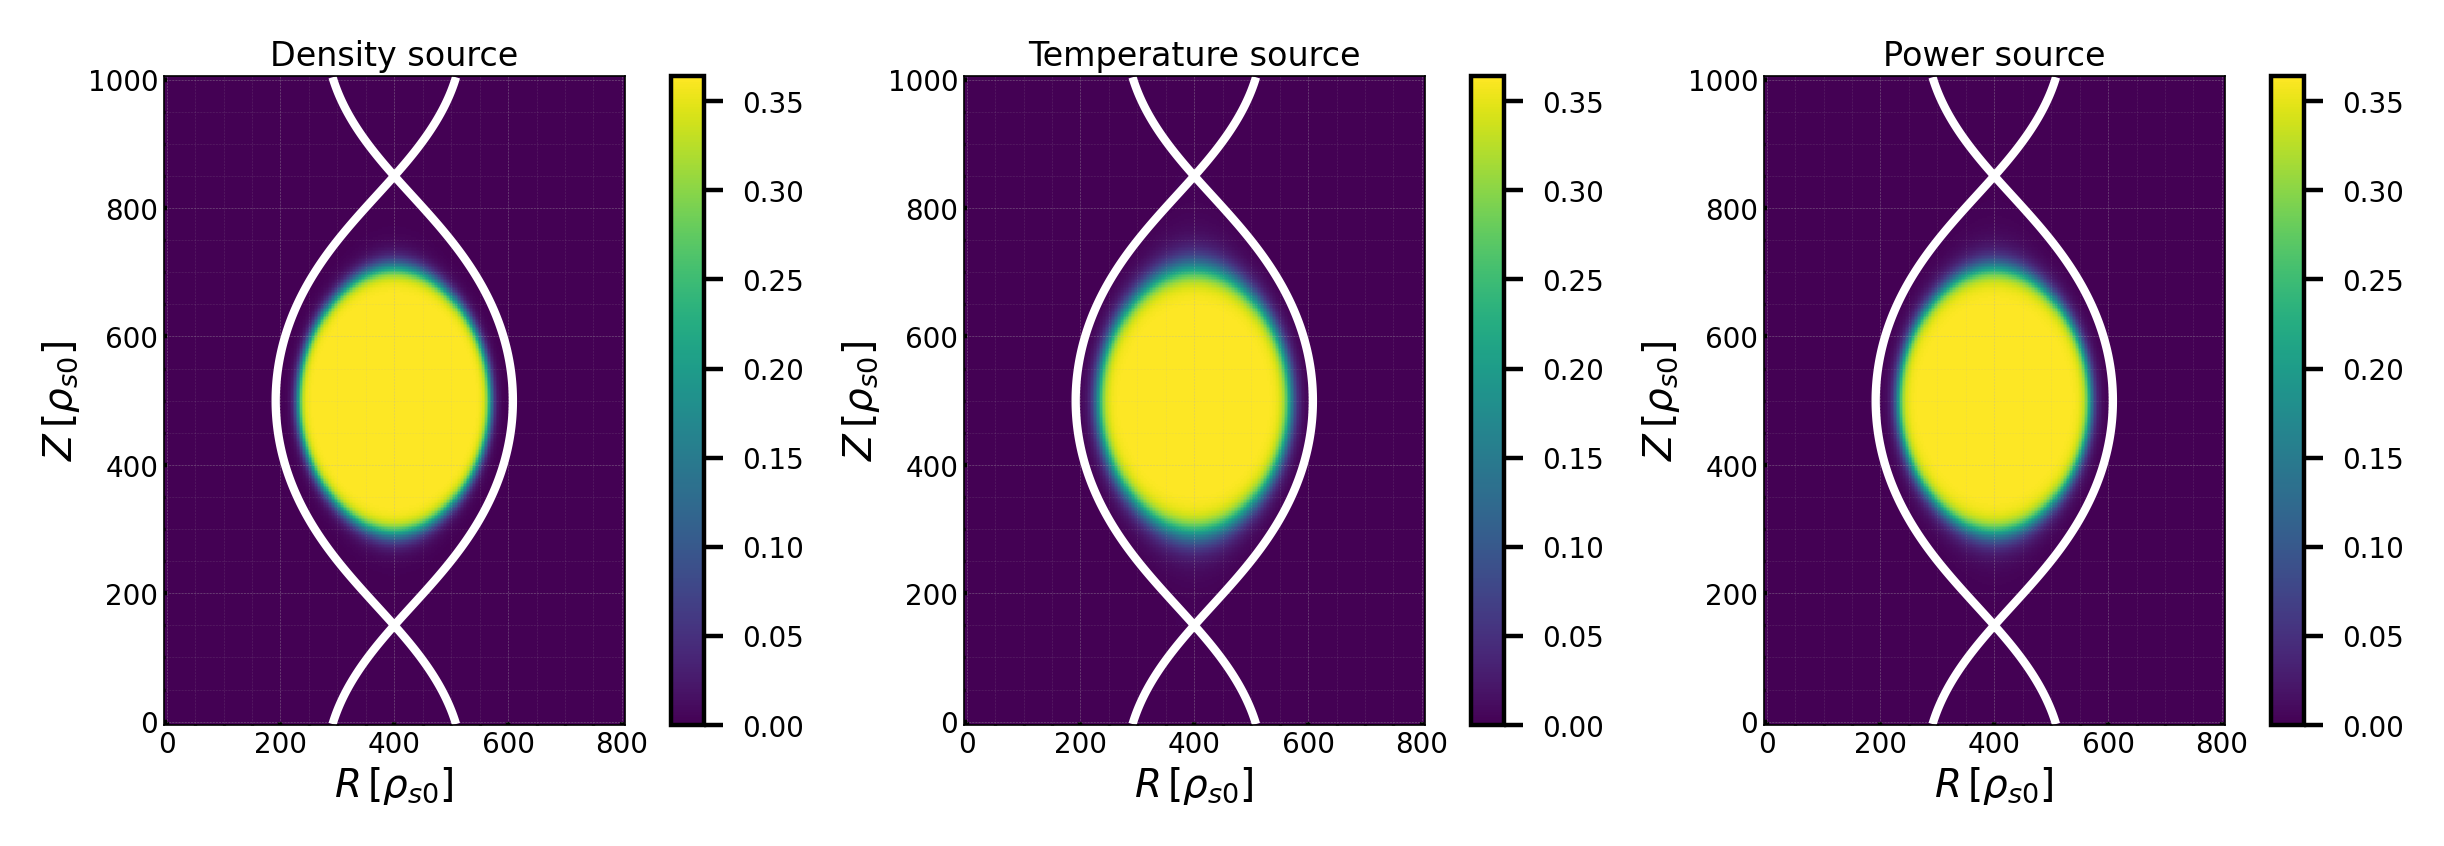

In [13]:
X, Y = np.meshgrid(s.x, s.y)
fig, axes = plt.subplots(ncols=3,  figsize=(6, 2),  dpi=400, constrained_layout=True)

cs = axes[0].pcolormesh(X, Y, Sn, cmap='viridis')
cs = axes[1].pcolormesh(X, Y, St, cmap='viridis')
cs = axes[2].pcolormesh(X, Y, Sp, cmap='viridis')

axes[0].set_title('Density source', size=6, pad=2)
axes[1].set_title('Temperature source', size=6, pad=2)
axes[2].set_title('Power source', size=6, pad=2)

cbar1=fig.colorbar(cs, ax=axes[0])
cbar2=fig.colorbar(cs, ax=axes[1])
cbar3=fig.colorbar(cs, ax=axes[2])
cbar1.ax.tick_params(labelsize=5); cbar2.ax.tick_params(labelsize=5); cbar3.ax.tick_params(labelsize=5) 

axes[0].contour(X, Y, s.Psi, levels=[s.Psi[s.iyxpt, s.ixxpt]],colors='w')
axes[1].contour(X, Y, s.Psi, levels=[s.Psi[s.iyxpt, s.ixxpt]],colors='w')
axes[2].contour(X, Y, s.Psi, levels=[s.Psi[s.iyxpt, s.ixxpt]],colors='w')

for ax in axes:
    ax.set_xlabel('x')
    ax.set_ylabel('y')

for ax in axes:
    ax.grid(True, which='major', alpha=1., linestyle=':', linewidth=0.1)
    ax.grid(True, which='minor', alpha=0.4, linestyle=':', linewidth=0.1)
    ax.xaxis.set_minor_locator(AutoMinorLocator())
    ax.yaxis.set_minor_locator(AutoMinorLocator())
    ax.tick_params(axis='x', labelsize=5, pad=1)
    ax.tick_params(axis='y', labelsize=5, pad=1)
    ax.tick_params(which='minor', direction="in", size=0.2)
    ax.tick_params(which='major', direction="in", size=0.5)
    ax.spines["bottom"].set_linewidth(0.3)
    ax.spines["left"].set_linewidth(0.3)
    ax.spines["right"].set_linewidth(0.3)
    ax.spines["top"].set_linewidth(0.3)
    ax.set_xlabel(r'$R \,[\rho_{s0}]$', fontsize=7, labelpad=1)
    ax.set_ylabel(r'$Z\, [\rho_{s0}]$', fontsize=7, rotation=90, labelpad=1)
    #ax.legend(bbox_to_anchor=(0.35, 1), loc='upper right', edgecolor='white', prop={'size': 2}, facecolor='white' )
    
#plt.gca().set_aspect('equal')
plt.show(block=False)


# Save source profiles in hdf5

In [15]:
from gbspy.sources import write_const_plasma_sources
#write_const_plasma_sources("DNT_dn0p6.h5", theta=Sn_3D, tempe=St_3D, tempi=St_3D, shape=(1,244,324), filemode="w-")
#write_const_plasma_sources("DPT_d0p6.h5", theta=Sn_3D, tempe=St_3D, tempi=St_3D, shape=(1,244,324), filemode="w-")
write_const_plasma_sources("DN_neu.h5", theta=Sn_3D, tempe=St_3D, tempi=St_3D, shape=(1,304,404), filemode="w-")

# Check the generated source profile

In [34]:
with h5py.File("DPT_d0p6.h5", "r") as f:
    src_theta_DN=f["sources/theta"][:]
    src_tempe_DN=f["sources/tempe"][:]
    src_tempi_DN=f["sources/tempi"][:]
    

src_theta_DN = np.transpose(np.mean(src_theta_DN, axis=0))
src_tempe_DN = np.transpose(np.mean(src_tempe_DN, axis=0))
src_tempi_DN = np.transpose(np.mean(src_tempi_DN, axis=0))

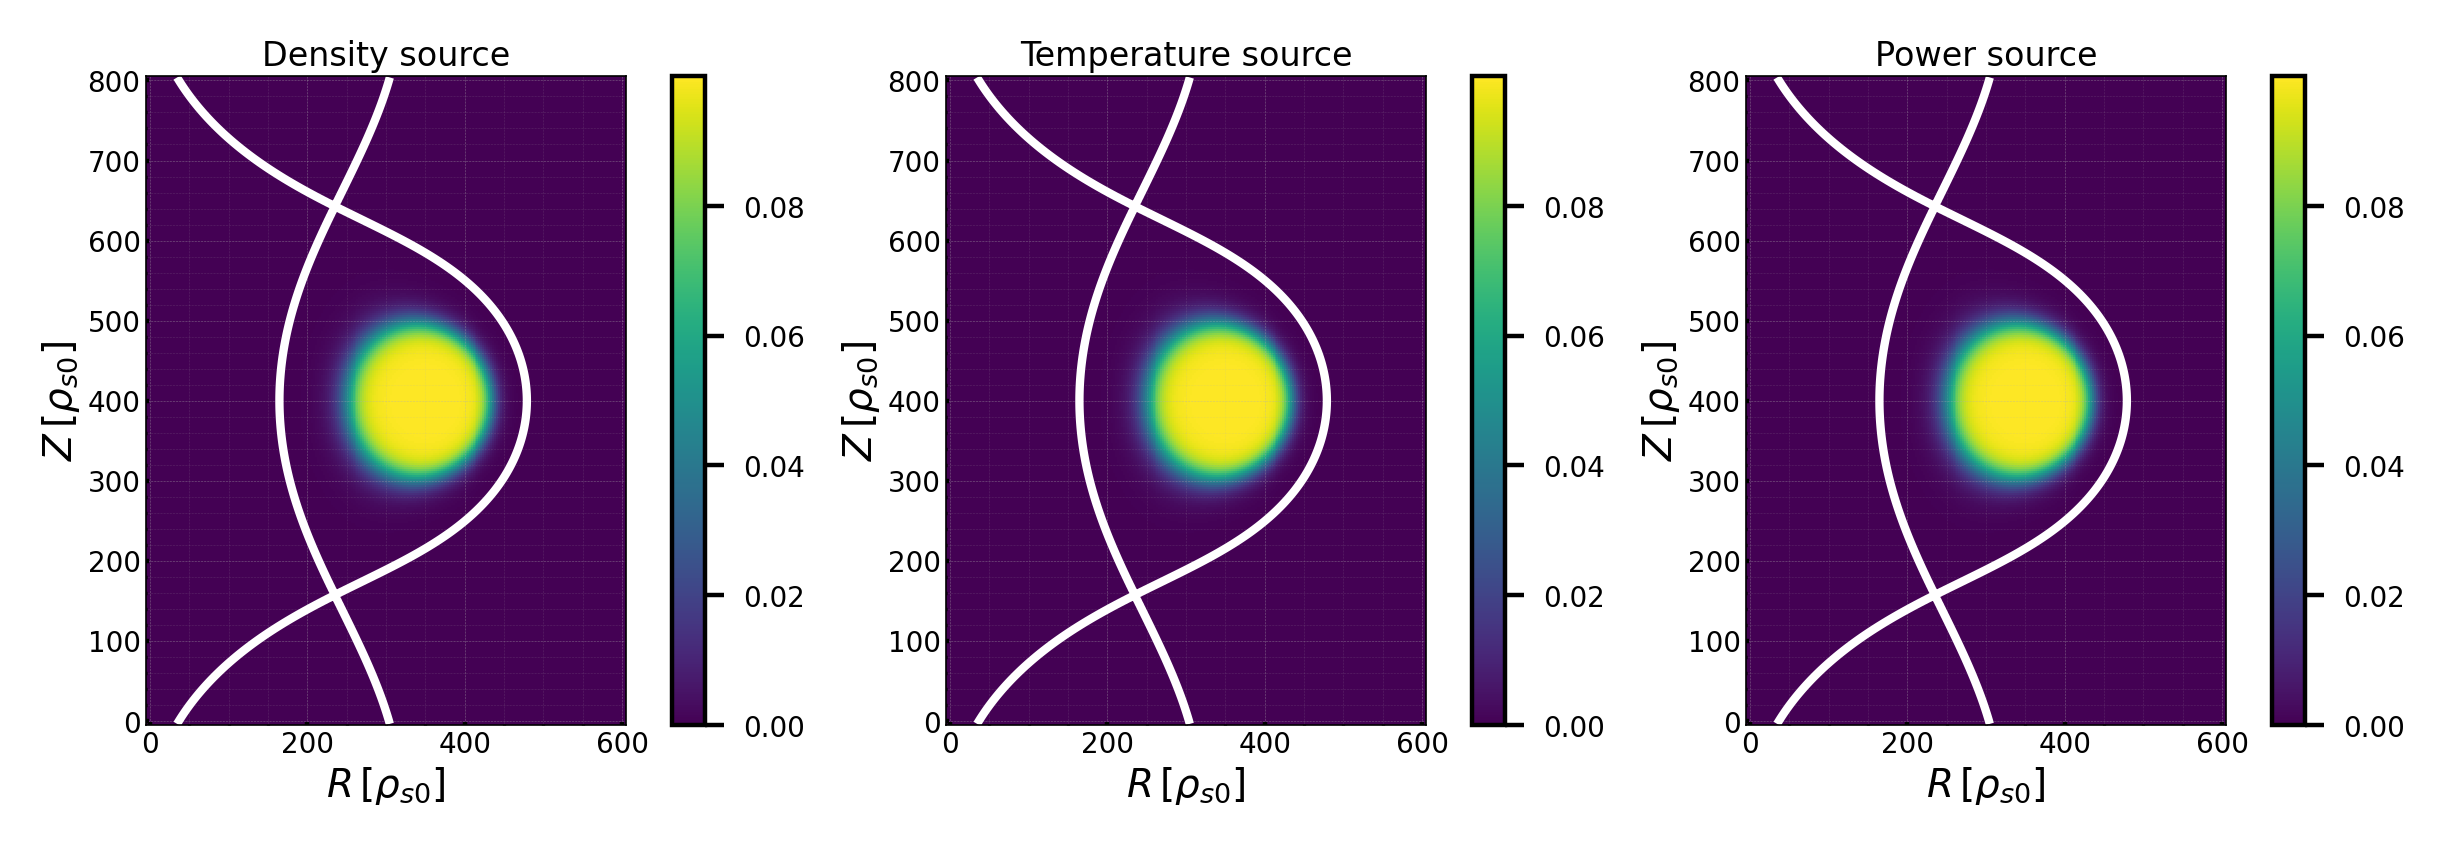

In [35]:
X, Y = np.meshgrid(s.x, s.y)
fig, axes = plt.subplots(ncols=3,  figsize=(6, 2),  dpi=400, constrained_layout=True)

cs = axes[0].pcolormesh(X, Y, src_theta_DN, cmap='viridis')
cs = axes[1].pcolormesh(X, Y, src_tempe_DN, cmap='viridis')
cs = axes[2].pcolormesh(X, Y, src_tempi_DN, cmap='viridis')

axes[0].set_title('Density source', size=6, pad=2)
axes[1].set_title('Temperature source', size=6, pad=2)
axes[2].set_title('Power source', size=6, pad=2)

cbar1=fig.colorbar(cs, ax=axes[0])
cbar2=fig.colorbar(cs, ax=axes[1])
cbar3=fig.colorbar(cs, ax=axes[2])
cbar1.ax.tick_params(labelsize=5); cbar2.ax.tick_params(labelsize=5); cbar3.ax.tick_params(labelsize=5) 

axes[0].contour(X, Y, s.Psi, levels=[s.Psi[s.iyxpt, s.ixxpt]],colors='w')
axes[1].contour(X, Y, s.Psi, levels=[s.Psi[s.iyxpt, s.ixxpt]],colors='w')
axes[2].contour(X, Y, s.Psi, levels=[s.Psi[s.iyxpt, s.ixxpt]],colors='w')

for ax in axes:
    ax.set_xlabel('x')
    ax.set_ylabel('y')

for ax in axes:
    ax.grid(True, which='major', alpha=1., linestyle=':', linewidth=0.1)
    ax.grid(True, which='minor', alpha=0.4, linestyle=':', linewidth=0.1)
    ax.xaxis.set_minor_locator(AutoMinorLocator())
    ax.yaxis.set_minor_locator(AutoMinorLocator())
    ax.tick_params(axis='x', labelsize=5, pad=1)
    ax.tick_params(axis='y', labelsize=5, pad=1)
    ax.tick_params(which='minor', direction="in", size=0.2)
    ax.tick_params(which='major', direction="in", size=0.5)
    ax.spines["bottom"].set_linewidth(0.3)
    ax.spines["left"].set_linewidth(0.3)
    ax.spines["right"].set_linewidth(0.3)
    ax.spines["top"].set_linewidth(0.3)
    ax.set_xlabel(r'$R \,[\rho_{s0}]$', fontsize=7, labelpad=1)
    ax.set_ylabel(r'$Z\, [\rho_{s0}]$', fontsize=7, rotation=90, labelpad=1)
    #ax.legend(bbox_to_anchor=(0.35, 1), loc='upper right', edgecolor='white', prop={'size': 2}, facecolor='white' )
    
#plt.gca().set_aspect('equal')
plt.show(block=False)
